In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import requests_cache
import matplotlib.pyplot as plt


# Implementation of Black-Scholes formula in Python
# Define variables 
# r is the risk-free rate
# S is the current stock price
# K is the option strike price
# T is the time to maturity
# sigma is the volatility of the stock

def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

def theta_calc(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            theta_calc = -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            theta_calc = -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
        return theta_calc/365
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

def calculate_prob_profit_bs(S, K, T, r, sigma, type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if type == 'c':
        prob_profit = norm.cdf(d2)
    else:  # for put option
        prob_profit = norm.cdf(-d2)
    
    return prob_profit

def get_option_data(stock_symbol='JPM', session=None):
    # Load data
    stock = yf.Ticker(stock_symbol, session=session)
    # Get stock option information
    all_call_data = []
    all_put_data = []
    option_dates = stock.options
    for date in option_dates:
        option_data = stock.option_chain(date)
        # print(type(option_data.calls))
        
        call_data = option_data.calls
        put_data = option_data.puts
        
        call_data['date'] = date
        put_data['date'] = date
        call_data['stock_symbol'] = stock_symbol
        put_data['stock_symbol'] = stock_symbol

        call_data['Option Income'] = call_data['lastPrice'] * 100
        call_data['Break Even'] = call_data['strike'] + call_data['lastPrice']
        # call_data['Total Income'] = call_data['Option Income'] + (call_data['strike'] * 100)

        put_data['Option Income'] = put_data['lastPrice'] * 100
        put_data['Break Even'] = put_data['strike'] - put_data['lastPrice']
        # put_data['Total Income'] = put_data['Option Income'] + (put_data['strike'] * 100)

        all_call_data.append(option_data.calls)
        all_put_data.append(option_data.puts)


    # print(all_call_data[0])

    return all_call_data, all_put_data


def get_stock_price_history(stock_symbol='JPM', session=None):
    # Load data
    stock = yf.Ticker(stock_symbol, session=session) 
    # Get stock price history
    stock_data = stock.history(period='3mo')
    return stock_data

In [36]:
session = requests_cache.CachedSession('yfinance.cache')
session.headers['User-agent'] = 'my-program/1.0'
price_data = get_stock_price_history('JPM', session=session)
options_call_data, options_put_data = get_option_data('JPM', session=session)
price_data['Daily_Returns'] = (price_data['Close'] / price_data['Close'].shift(1)) - 1

In [39]:
options_put_data[0].head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,date,stock_symbol,Option Income,Break Even,Total Income,BS Price,Delta,Theta,Prob Profit,Expected Return
0,JPM240802P00110000,2024-07-23 19:45:33+00:00,110.0,0.01,0.0,0.01,0.0,0.0,NaN,17,...,2024-08-02,JPM,1.0,109.99,11001.0,NaN,NaN,NaN,NaN,NaN
1,JPM240802P00120000,2024-06-27 15:03:13+00:00,120.0,0.05,0.0,0.01,0.0,0.0,NaN,13,...,2024-08-02,JPM,5.0,119.95,12005.0,NaN,NaN,NaN,NaN,NaN
2,JPM240802P00150000,2024-07-22 19:28:05+00:00,150.0,0.01,0.0,1.01,0.0,0.0,11.0,11,...,2024-08-02,JPM,1.0,149.99,15001.0,NaN,NaN,NaN,NaN,NaN
3,JPM240802P00155000,2024-07-22 13:30:02+00:00,155.0,0.13,0.0,1.26,0.0,0.0,1.0,2,...,2024-08-02,JPM,13.0,154.87,15513.0,NaN,NaN,NaN,NaN,NaN
4,JPM240802P00160000,2024-07-26 15:46:19+00:00,160.0,0.02,0.0,0.11,0.0,0.0,1.0,1538,...,2024-08-02,JPM,2.0,159.98,16002.0,NaN,NaN,NaN,NaN,NaN


In [54]:
daily_std = price_data['Daily_Returns'].std()
sigma = daily_std * np.sqrt(252)
r = 0.0425
s = price_data['Close'].iloc[-1]

# # print(options_put_data[0])
for i in range(len(options_put_data)):
    # Need to deal with the date minus due to -1 answer when subtracting dates during overlaps (Close date = current date)
    t = (pd.to_datetime(options_put_data[i]['date'][0]) - pd.to_datetime('today')).days/365
    options_put_data[i]['BS Price'] = blackScholes(r=r, S=s, K = options_put_data[i]['strike'], T=t, sigma=sigma, type='p')
    options_put_data[i]['Delta'] = delta_calc(r=r, S=s, K = options_put_data[i]['strike'], T=t, sigma=sigma, type='p')
    options_put_data[i]['Theta'] = theta_calc(r=r, S=s, K = options_put_data[i]['strike'], T=t, sigma=sigma, type='p')
    options_put_data[i]['Prob Profit'] = calculate_prob_profit_bs(r=r, S=s, K = options_put_data[i]['strike'], T=t, sigma=sigma, type='p')
    options_put_data[i]['Expected Option-Income Return'] = (1 - options_put_data[i]['Prob Profit']) * options_put_data[i]['Option Income']

for i in range(len(options_call_data)):
    t = (pd.to_datetime(options_call_data[i]['date'][0]) - pd.to_datetime('today')).days/365
    options_call_data[i]['BS Price'] = blackScholes(r=r, S=s, K = options_call_data[i]['strike'], T=t, sigma=sigma, type='c')
    options_call_data[i]['Delta'] = delta_calc(r=r, S=s, K = options_call_data[i]['strike'], T=t, sigma=sigma, type='c')
    options_call_data[i]['Theta'] = theta_calc(r=r, S=s, K = options_call_data[i]['strike'], T=t, sigma=sigma, type='c')
    options_call_data[i]['Prob Profit'] = calculate_prob_profit_bs(r=r, S=s, K = options_call_data[i]['strike'], T=t, sigma=sigma, type='c')
    options_call_data[i]['Expected Option-Income Return'] = (1 - options_call_data[i]['Prob Profit']) * options_call_data[i]['Option Income']



/tmp/ipykernel_790/3931041734.py:19: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
/tmp/ipykernel_790/3931041734.py:20: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma*np.sqrt(T)
/tmp/ipykernel_790/3931041734.py:32: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
/tmp/ipykernel_790/3931041734.py:44: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
/tmp/ipykernel_790/3931041734.py:45: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma*np.sqrt(T)
/tmp/ipykernel_790/3931041734.py:50: RuntimeWarning: invalid value encountered in sqrt
  theta_calc = -S*norm.pdf(d1, 0, 1)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
/tmp/ipykernel_790/3931041734.py:56: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (

In [55]:
options_put_data[1]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,Option Income,Break Even,Total Income,BS Price,Delta,Theta,Prob Profit,Expected Return,Expected Option-Income Return,Expected Total-Income Return
0,JPM240809P00110000,2024-07-08 19:45:47+00:00,110.0,0.05,0.00,0.01,0.00,0.00000,NaN,2,...,5.0,109.95,11005.0,1.502044e-119,-6.086998e-119,-6.727263e-118,1.152945e-118,5.000000,5.000000,11005.000000
1,JPM240809P00150000,2024-07-22 14:24:44+00:00,150.0,0.05,0.00,0.12,0.00,0.00000,NaN,3,...,5.0,149.95,15005.0,2.854559e-33,-5.997371e-33,-3.416031e-32,8.339610e-33,5.000000,5.000000,15005.000000
2,JPM240809P00165000,2024-07-31 13:40:53+00:00,165.0,0.02,0.01,0.10,0.00,0.00000,8.0,26,...,2.0,164.98,16502.0,1.060464e-17,-1.599298e-17,-6.492577e-17,2.023537e-17,2.000000,2.000000,16502.000000
3,JPM240809P00170000,2024-07-31 17:30:27+00:00,170.0,0.01,0.01,0.08,0.00,0.00000,1.0,30,...,1.0,169.99,17001.0,7.187092e-14,-9.517946e-14,-3.378774e-13,1.169369e-13,1.000000,1.000000,17001.000000
4,JPM240809P00175000,2024-07-31 15:28:26+00:00,175.0,0.03,0.02,0.20,0.00,0.00000,67.0,121,...,3.0,174.97,17503.0,1.271123e-10,-1.458405e-10,-4.458584e-10,1.741565e-10,3.000000,3.000000,17502.999997
5,JPM240809P00180000,2024-08-01 19:04:01+00:00,180.0,0.07,0.06,0.08,0.04,133.33333,114.0,354,...,7.0,179.93,18007.0,6.589750e-08,-6.440860e-08,-1.662684e-07,7.483176e-08,6.999999,6.999999,18006.998653
6,JPM240809P00185000,2024-08-01 19:08:37+00:00,185.0,0.11,0.10,0.12,-0.27,-71.05263,382.0,107,...,11.0,184.89,18511.0,1.116379e-05,-9.099013e-06,-1.932110e-05,1.029581e-05,10.999887,10.999887,18510.809414
7,JPM240809P00190000,2024-08-01 17:37:19+00:00,190.0,0.20,0.16,0.19,0.13,185.71426,164.0,497,...,20.0,189.80,19020.0,6.858894e-04,-4.535574e-04,-7.641202e-04,5.003900e-04,19.989992,19.989992,19010.482583
8,JPM240809P00192500,2024-08-01 19:04:01+00:00,192.5,0.26,0.21,0.24,0.17,188.88885,37.0,82,...,26.0,192.24,19276.0,3.795578e-03,-2.232223e-03,-3.289464e-03,2.432913e-03,25.936744,25.936744,19229.103161
9,JPM240809P00195000,2024-08-01 19:23:43+00:00,195.0,0.35,0.29,0.40,0.27,337.49990,181.0,210,...,35.0,194.65,19535.0,1.694734e-02,-8.776071e-03,-1.113614e-02,9.452854e-03,34.669150,34.669150,19350.338493


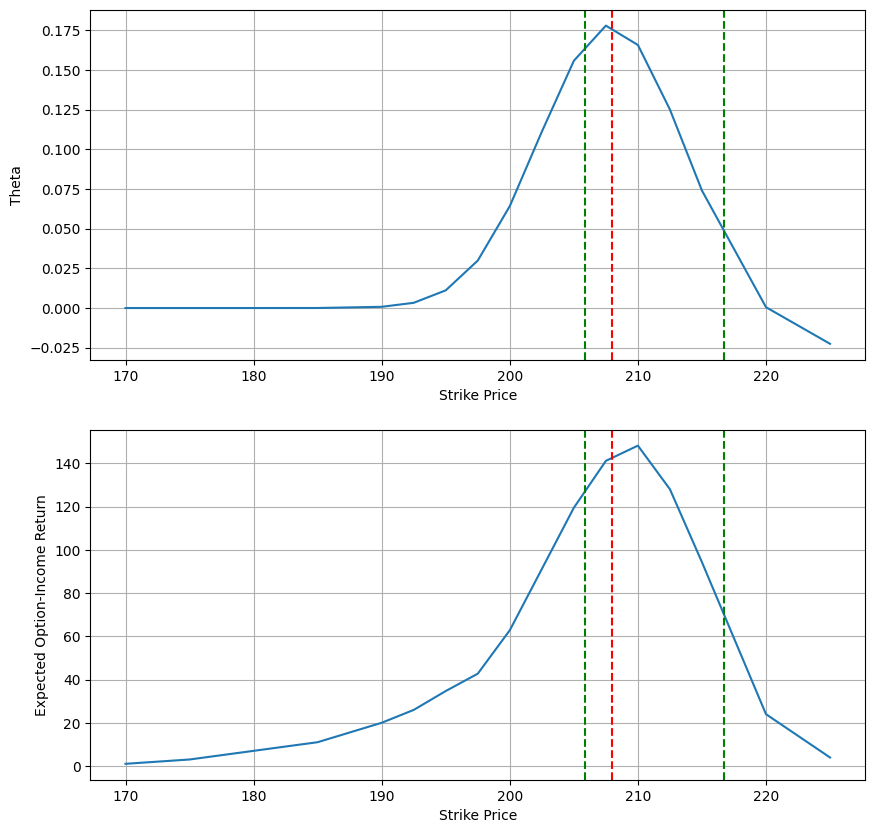

In [58]:
lower_bound = price_data.iloc[-1]['Close'] * 0.8
upper_bound = price_data.iloc[-1]['Close'] * 1.2


# Plot only the options that are within the range of 20% of the current stock price
filtered_data = options_put_data[1][(options_put_data[1]['strike'] > lower_bound) & (options_put_data[1]['strike'] < upper_bound)]

# Calculate the days to expiration
exp_day = (pd.to_datetime(filtered_data['date'].iloc[0]) - pd.to_datetime('today')).days

# Calculate the SMA and Bollinger Bands
sma = price_data['Close'].rolling(window=exp_day).mean()
std = price_data['Close'].rolling(window=exp_day).std()
upper_band = sma + (2 * std)
lower_band = sma - (2 * std)

# print(upper_band)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(filtered_data['strike'], (filtered_data['Theta']* -1))
# Vertical line for current stock price and bollinger bands
plt.axvline(upper_band.iloc[-1], color='g', linestyle='--')
plt.axvline(lower_band.iloc[-1], color='g', linestyle='--')
plt.axvline(price_data.iloc[-1]['Close'], color='r', linestyle='--')
plt.xlabel('Strike Price')
plt.ylabel('Theta')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(filtered_data['strike'], filtered_data['Expected Option-Income Return'])
# Vertical line for current stock price and bollinger bands
plt.axvline(upper_band.iloc[-1], color='g', linestyle='--')
plt.axvline(lower_band.iloc[-1], color='g', linestyle='--')
plt.axvline(price_data.iloc[-1]['Close'], color='r', linestyle='--')
plt.xlabel('Strike Price')
plt.ylabel('Expected Option-Income Return')
plt.grid()
plt.show()